In [2]:
# Insight Data Challenge

# Yiyun Lan 

#=====================
# Problem Description
#=====================

# Data link
# https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
# Format
#1. Sample code number: id number 
#2. Clump Thickness: 1 - 10 
#3. Uniformity of Cell Size: 1 - 10 
#4. Uniformity of Cell Shape: 1 - 10 
#5. Marginal Adhesion: 1 - 10 
#6. Single Epithelial Cell Size: 1 - 10 
#7. Bare Nuclei: 1 - 10 
#8. Bland Chromatin: 1 - 10 
#9. Normal Nucleoli: 1 - 10 
#10. Mitoses: 1 - 10 
#11. Class: (2 for benign, 4 for malignant)

#=========
# Approach
#=========

# 1. Data cleaning
# 2. Descriptive analysis
# 3. Training set: 75%, Testing Set: 25%, no cross-validation applied
# 3. Feature analysis: correlation, covariance, relevance, importance
# 4. Prediction 1) using Random Forest 2) using Linear Discriminant Analysis

#========
# Results
#========

# With all 9 features, Random Forest (tree number = 70) produced an overall prediction of 98.5% (Benign: 97%
# Malignant: 100%). Linear Discriminant Analysis produced an overall prediction of 97.5% (Benign: 99%, Malignant: 95%)


In [363]:
import urllib
import pandas as pd
import sys
from StringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.lda
import sklearn.cross_validation
from string import letters
import seaborn as sns
from collections import OrderedDict

In [293]:
# read in data and store it in df
link = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
f = urllib.urlopen(link)           
myfile = f.read()
names = ['sample_num', 'thickness', 'size', 'shape', 'adhesion', 'single_size',
         'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'label']
df = pd.read_csv(StringIO(myfile), names = names)

In [294]:
# clean data
df = df[df.bare_nuclei != '?']  # remove ? values in 16 rows in the 'bare_nuclei column
df.bare_nuclei = pd.to_numeric(df.bare_nuclei) # convert string to numerical in the bare_nuclei column

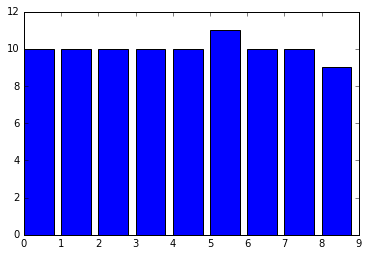

In [95]:
# sanity check
%matplotlib inline
## check no null/inf data
df.replace([np.inf, -np.inf], np.nan)
df.isnull().values.any() 
## check categorical data
unique_values = [len(np.unique(df[i])) for i in names] 
plt.bar(range(df.shape[1]-2), unique_values[1:-1])
plt.show()

In [219]:
# descriptive analysis 1
df.shape
benign = df[df['class']== 2]
malignant = df[df['class']== 4]
1.0*len(benign)/len(malignant) # benign size is almost twice as malignant size

1.900414937759336

In [408]:
train, test = sklearn.cross_validation.train_test_split(df, test_size = 0.25, train_size = 0.75, random_state = 123)

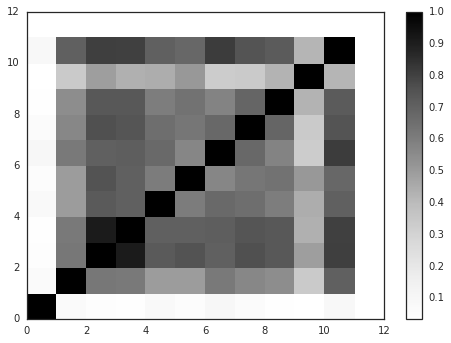

In [412]:
# size and shape are correlated features, so they are subject to being redundant 
plt.pcolor(np.abs(np.corrcoef(train.T)))
plt.colorbar()

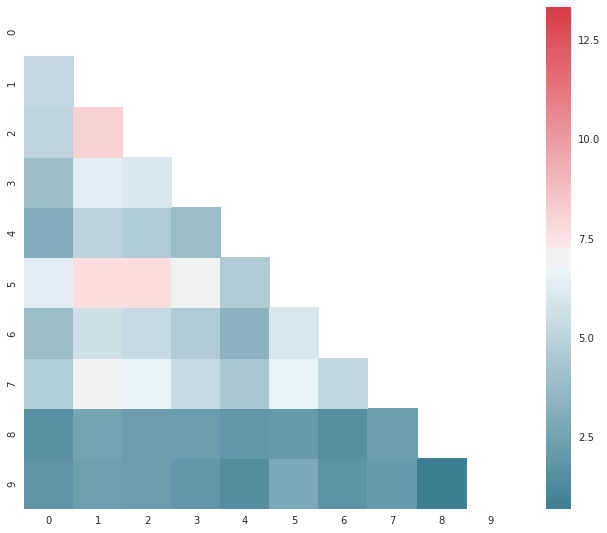

In [413]:
# covariance matrix: all features have similar covariance with the label class.
sns.set(style="white")

## Compute the correlation matrix
corr = np.cov(train.drop('sample_num',1).T)

## Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

## Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

## Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap)

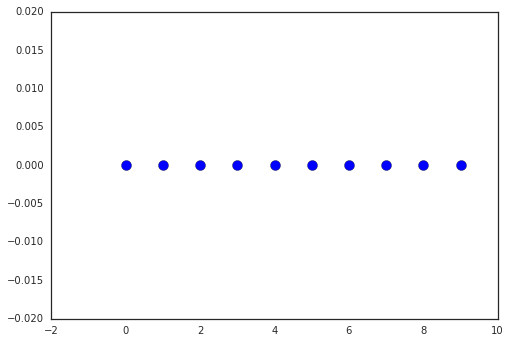

In [414]:
# feature relevance test
F = len(names[1:])
probabilities = [scipy.stats.mannwhitneyu(train[train.label==2][i], train[train.label==4][i])[1] for i in names[1:]]
plt.scatter(range(F), probabilities, 100)

In [415]:
model = sklearn.lda.LDA()
scores = sklearn.cross_validation.cross_val_score(model, train.drop(['label'], 1), train.label, cv=5)
print np.mean(scores), np.std(scores)

0.955165912519 0.0178465538613


<Container object of 9 artists>

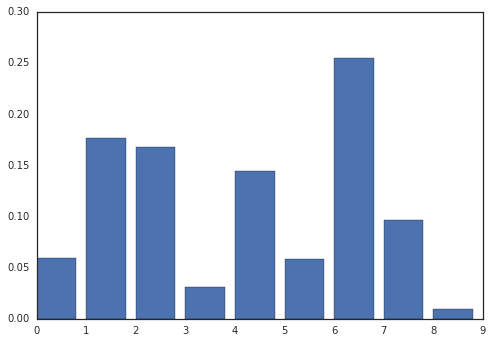

In [420]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
# load the iris datasets
dataset = train.drop(['sample_num','label'], 1)
# fit an Extra Trees model to the data
model = sklearn.ensemble.RandomForestClassifier()
model.fit(dataset, train.label)
# display the relative importance of each attribute
plt.bar(range(9), model.feature_importances_)

In [421]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE

# load the iris datasets
dataset = train.drop(['sample_num','label'], 1)
# create a base classifier used to evaluate a subset of attributes
model = sklearn.ensemble.RandomForestClassifier()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(dataset, train.label)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False  True False  True False]
[5 1 2 6 3 1 4 1 7]


In [423]:
scores = sklearn.cross_validation.cross_val_score(model, train.drop(['label'],1), train['label'], cv=3)
train_scale = sklearn.preprocessing.StandardScaler().fit(train.drop(['label'],1))
train_transform = train_scale.transform(train.drop(['label'],1))
test_scale = sklearn.preprocessing.StandardScaler().fit(test.drop(['label'],1))
test_transform = train_scale.transform(test.drop(['label'],1))

/Users/lanyiyun/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


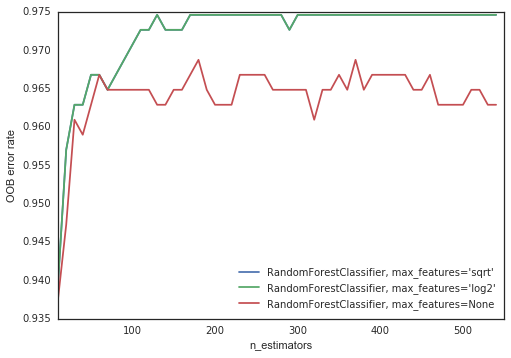

In [424]:
# estimate the number of trees needed to reach certain prediction accuracy

RANDOM_STATE = 123
ensemble_clfs = [
  ("RandomForestClassifier, max_features='sqrt'",
      RandomForestClassifier(warm_start=False, oob_score=True,
                             max_features="sqrt",
                             random_state=RANDOM_STATE)),
  ("RandomForestClassifier, max_features='log2'",
      RandomForestClassifier(warm_start=False, max_features='log2',
                             oob_score=True,
                             random_state=RANDOM_STATE)),
  ("RandomForestClassifier, max_features=None",
      RandomForestClassifier(warm_start=False, max_features=None,
                             oob_score=True,
                             random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 550

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators,10):
        clf.set_params(n_estimators=i)
        clf.fit(train_transform, train['label'])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="lower right")
plt.show()

('1st sample from test dataset classified as:', array([2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4,
       2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 4, 2, 4,
       2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 4, 2, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 2,
       4, 2, 2, 4, 2, 2, 4, 4, 4, 4]))
('actual class label:', 154    2
687    2
80     2
269    2
136    2
573    2
81     2
476    2
59     4
216    2
45     2
170    2
548    2
428    2
296    2
520    2
168    2
587    2
141    2
206    4
187    4
473    2
358    4
380    2
664    2
11     2
623    2
622    2
227    4
392    2
      ..
630    2
649    2
176    2
459    2
208    2
618    2
124    4
42     4
104   

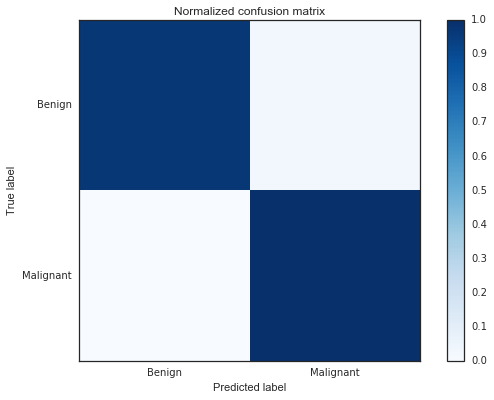

In [434]:
# fit model
## RF model with 70 trees
lda_clf = sklearn.ensemble.RandomForestClassifier(70)
#lda_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=15)
lda_clf.fit(train_transform, train['label'])
# sklearn.lda.LDA(n_components=None, priors=None)

# prediction
print('1st sample from test dataset classified as:', lda_clf.predict(test_transform))
print('actual class label:', test['label'])
# confusion matrix
print('Confusion Matrix of the LDA-classifier')
print(metrics.confusion_matrix(test['label'], lda_clf.predict(test_transform)))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'])
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = lda_clf.predict(test_transform)
y_test = test['label']
    
# Compute confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

('1st sample from test dataset classified as:', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4,
       2, 2, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 4, 2, 4,
       2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 4, 2, 4, 2, 2,
       4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2,
       4, 4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 4, 2, 2, 4, 4, 2, 4, 4, 2,
       2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 4, 2,
       4, 2, 2, 2, 2, 2, 4, 4, 4, 4]))
('actual class label:', 154    2
687    2
80     2
269    2
136    2
573    2
81     2
476    2
59     4
216    2
45     2
170    2
548    2
428    2
296    2
520    2
168    2
587    2
141    2
206    4
187    4
473    2
358    4
380    2
664    2
11     2
623    2
622    2
227    4
392    2
      ..
630    2
649    2
176    2
459    2
208    2
618    2
124    4
42     4
104   

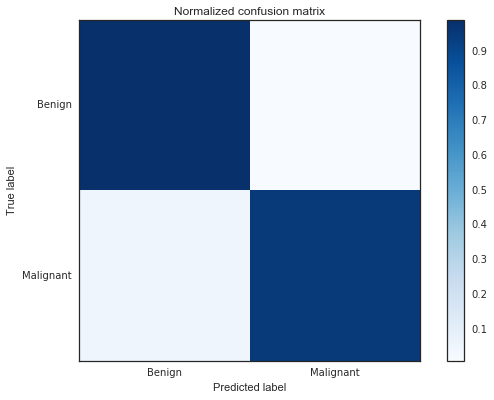

In [427]:
# fit model
## lda model
lda_clf = sklearn.lda.LDA()
#lda_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=15)
lda_clf.fit(train_transform, train['label'])
# sklearn.lda.LDA(n_components=None, priors=None)

# prediction
print('1st sample from test dataset classified as:', lda_clf.predict(test_transform))
print('actual class label:', test['label'])
# confusion matrix
print('Confusion Matrix of the LDA-classifier')
print(metrics.confusion_matrix(test['label'], lda_clf.predict(test_transform)))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'])
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = lda_clf.predict(test_transform)
y_test = test['label']
    
# Compute confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()